「ニューラルネットワーク入門」
===============================================================
【原題】NEURAL NETWORKS

【原著】[Soumith Chintala](http://soumith.ch/)

【元URL】https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　徳原 光

【日付】2020年10月27日

【チュトーリアル概要】

画像処理用のシンプルなニューラルネットワークの基本的な構築手順を、実装しながら解説します。

---



ニューラルネットワーク
------------------

``torch.nn``パッケージを利用することで、ニューラルネットワークを構築することができます。


前回のチュートリアルでは``autograd``について確認しましたが、``nn``はモデルを定義したり、モデルに微分を適用するために、``autograd``に依存しています。


``nn.Module``はレイヤーと、入力の順伝搬関数であり、``output``を返す関数``forward(input)``を含みます。

例として、手書き文字の画像を分類する以下のネットワークをご覧ください。




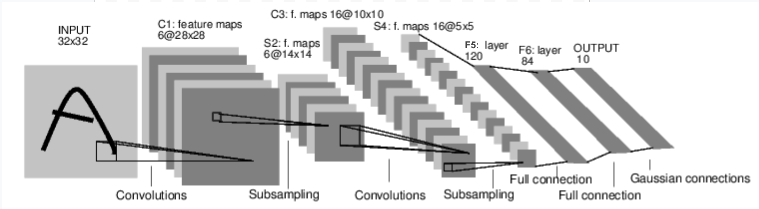



   **convnet**（ConvNetのモデル図）

上記の図はシンプルなフィードフォワードネットワークです。

入力を受けると、それがいくつか層を介して次々と伝わっていき、最終的に出力を得ることができます。

ニューラルネットワークの典型的な学習手順は次のようになります。

- 学習可能なパラメータ(重み)を持つニューラルネットワークを定義
- 入力のデータセットに対してループ処理
- ネットワークを介して入力を演算
- 損失（正解からどのくらい出力が乖離しているか）を計算
- 勾配をネットワークのパラメータに逆伝播
- ネットワークの重みを更新。通常は、単純な更新ルールを使用:
  ``重み = 重み - 学習率 * 勾配``




ネットワークの定義
------------------

では、ネットワークを定義してみましょう:

In [7]:
%matplotlib inline

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


実装者は``forward``関数だけ定義するだけでよく、``autograd``を使用して``backward``関数（勾配を計算する逆伝搬関数）は自動的に定義されます。

``forward``関数内ではどのようなTensor操作も使用可能です。

<br> 

モデルの学習可能なパラメータは ``net.parameters()``によって取得できます。



In [9]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


それでは、ランダムな32x32の入力を試してみましょう。

<br>

注意：このネットワーク（LeNet）が想定している入力のサイズは32×32になります。

このネットワークをMNISTデータセットで利用する場合は，データセットの画像を32×32にリサイズする必要があります。

（日本語訳注：MNISTデータセットは手書き文字のデータセットで各画像のサイズは28×28です）



In [10]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0811,  0.0097, -0.0433,  0.0996,  0.0454,  0.1059,  0.0275,  0.1259,
         -0.1766, -0.1785]], grad_fn=<AddmmBackward>)


テンソルに蓄積している勾配のバッファーを一度すべて0に初期化し、その後、乱数入力に対する勾配を誤差逆伝播させます。



In [11]:
net.zero_grad()
out.backward(torch.randn(1, 10))

[注意]

torch.nn はミニバッチのみをサポートしています。

torch.nn パッケージ全てにおいて、サポートされている入力は、単一サンプルではなく、サンプルのミニバッチになります。

（日本語訳注：ミニバッチとは、データセットからサンプルを複数個取り出してまとめたものを指します）



そのため例えば、``nn.Conv2d``は、``nSamples x nChannels x Height x Width``の4次元テンソルを取り込みます。

単一のサンプルを使う場合は、```input.unsqueeze(0)```を使って、偽のバッチの次元を追加します。

次に進む前に、チュートリアルシリーズで、ここまでに取り扱ったクラスをおさらいしましょう。

**振り返り：**
  -  ``torch.Tensor`` - ``backward()``のような"autograd" 操作のサポートを有した *多次元配列* 。特定のTensor(テンソル) に関連した*勾配を保持* することも可能。
  
  -  ``nn.Module`` - ニューラルネットワークのモジュール。 *ネットワークの重みパラメータをカプセル化する便利な手法*であり、それらのパラメータをGPUに移動させたり、外部保存したり、ロードするためのヘルパー関数を持つ。
  
  -  ``nn.Parameter`` - Tensor（テンソル）の一種で、*モジュール*に属性変数として割り当てられたときに自動的にパラメータとして登録される。
  
  -  ``autograd.Function`` - autograd操作の順伝搬および逆伝播の定義*を実装する。すべての ``Tensor``操作は、その操作で生成した``Tensor``に少なくとも1つ以上の``Function``を関連付け、そのテンソルに対する計算履歴を符号化して保持している




**現時点で解説を終えた項目：**
  -  ニューラルネットワークの定義の仕方
  -  入力の処理と勾配の逆伝播

**解説の残りの項目：**
  -  損失の計算
  -  ネットワークの重みの更新

損失関数
-------------
損失関数は、（出力、目標）のペアを入力に、ニューラルネットワークの出力（output）が目標（target）からどれくらい乖離しているかを推定する値を計算します。

nnパッケージには、様々な [loss function(損失関数)](https://pytorch.org/docs/nn.html#loss-functions) が用意されています。

シンプルな損失関数としては、目標との平均二乗誤差を計算する``nn.MSELoss`` が挙げられます。





例えば：

In [12]:
output = net(input)
target = torch.randn(10)  # 適当な正解targetを用意
target = target.view(1, -1)  # 変数targetの形をoutputに合わせるよう変形
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.7896, grad_fn=<MseLossBackward>)


``.grad_fn`` 属性を使用して``loss`` を逆方向に追跡すると、 以下のような演算のグラフになります：



    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

そのため、``loss.backward()``を呼び出すと損失の対象にグラフ全体を与えて微分され、``requires_grad=True``となっているグラフ内のすべてのテンソルに、各勾配が累積された``.grad`` Tensorを持つことになります。

説明のために、いくつかのステップを遡ってみましょう。

In [13]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

誤差逆伝播
--------
損失の誤差逆伝播を実行するには、 ``loss.backward()``を呼び出します。

ただし、このままでは勾配が、既存の勾配の上にさらに蓄積してしまうので、まず既存の勾配を取り除く必要があります。


In [14]:
net.zero_grad()     # netのパラメータの勾配をゼロにする

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0096, -0.0070, -0.0064,  0.0164, -0.0008, -0.0049])


ここまで損失関数の扱い方を解説しました。

**参考：**

  ニューラルネットワークパッケージには、ディープニューラルネットワークの構築ブロックを形成する、様々なモジュールと損失関数が含まれています（
[nnパッケージのドキュメント](https://pytorch.org/docs/nn)）

**解説の残りの項目：**

  - ネットワークの重みの更新


重みを更新する
------------------
実際に使用されている手法で、最もシンプルな更新ルールは、確率勾配降下（SGD）です。:

    重み = 重み - 学習率 * 勾配



こちらの簡単なPythonのコードを使って実装することができます:

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

しかし、ニューラルネットワークを使用すると、SGD、Nesterov-SGD、Adam、RMSPropなど、様々なパラメータ最適化の更新則（オプティマイザー）を利用したくなるものです。


更新則の変更を容易にするために、これらのすべての手法を実装した``torch.optim``という小さなパッケージを用意しています。

これを使用するのは簡単です。


In [ ]:
import torch.optim as optim

# optimizerを作る
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 訓練ループの中で以下を実行:
optimizer.zero_grad()   # 勾配を0にする
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # パラメータを更新

[注意]

上記コード内の``optimizer.zero_grad()``部分で、勾配のバッファを手動で0に設定している点に着目してください。

誤差逆伝播法の項で説明したように勾配が蓄積されているため、それをリセットするために実装しています。

